### Detectron DBT 2 Challenge

versions: 
- Train with optimam dataset
- Local Train and evaluation done after the challenge.


TODO:
- Adding transformers
- adding normals
- adding two views.

- Convert to python code




In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'



In [2]:
# install dependencies: 
# !pip install pyyaml==5.1
import torch, torchvision
import tensorflow
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0 True
gcc (Ubuntu 5.4.0-6ubuntu1~16.04.11) 5.4.0 20160609
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
import torch
assert torch.__version__.startswith("1.7")
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os, json, cv2, random
# import os.Path
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [6]:
import os
import sys
import itertools

# fmt: off
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.insert(1, os.path.join(sys.path[0], '/home/robert/src/detr/detr'))
# fmt: on

import time
from typing import Any, Dict, List, Set

import torch

import detectron2.utils.comm as comm
from d2.detr import DetrDatasetMapper, add_detr_config
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import COCOEvaluator, verify_results

from detectron2.solver.build import maybe_add_gradient_clipping

### DETR section


In [7]:
class Trainer(DefaultTrainer):
    """
    Extension of the Trainer class adapted to DETR.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each builtin dataset.
        For your own dataset, you can simply create an evaluator manually in your
        script and do not have to worry about the hacky if-else logic here.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    @classmethod
    def build_train_loader(cls, cfg):
        if "Detr" == cfg.MODEL.META_ARCHITECTURE:
            mapper = DetrDatasetMapper(cfg, True)
        else:
            mapper = None
        return build_detection_train_loader(cfg, mapper=mapper)

    @classmethod
    def build_optimizer(cls, cfg, model):
        params: List[Dict[str, Any]] = []
        memo: Set[torch.nn.parameter.Parameter] = set()
        for key, value in model.named_parameters(recurse=True):
            if not value.requires_grad:
                continue
            # Avoid duplicating parameters
            if value in memo:
                continue
            memo.add(value)
            lr = cfg.SOLVER.BASE_LR
            weight_decay = cfg.SOLVER.WEIGHT_DECAY
            if "backbone" in key:
                lr = lr * cfg.SOLVER.BACKBONE_MULTIPLIER
            params += [{"params": [value], "lr": lr, "weight_decay": weight_decay}]

        def maybe_add_full_model_gradient_clipping(optim):  # optim: the optimizer class
            # detectron2 doesn't have full model gradient clipping now
            clip_norm_val = cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE
            enable = (
                cfg.SOLVER.CLIP_GRADIENTS.ENABLED
                and cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model"
                and clip_norm_val > 0.0
            )

            class FullModelGradientClippingOptimizer(optim):
                def step(self, closure=None):
                    all_params = itertools.chain(*[x["params"] for x in self.param_groups])
                    torch.nn.utils.clip_grad_norm_(all_params, clip_norm_val)
                    super().step(closure=closure)

            return FullModelGradientClippingOptimizer if enable else optim

        optimizer_type = cfg.SOLVER.OPTIMIZER
        if optimizer_type == "SGD":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.SGD)(
                params, cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM
            )
        elif optimizer_type == "ADAMW":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.AdamW)(
                params, cfg.SOLVER.BASE_LR
            )
        else:
            raise NotImplementedError(f"no optimizer type {optimizer_type}")
        if not cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model":
            optimizer = maybe_add_gradient_clipping(cfg, optimizer)
        return optimizer


## end DETR

In [8]:
# unregister dataset
# given the error : Dataset 'balloon_train' is already registered!

DatasetCatalog.clear()

#unregister_dataset('ballon_train')



In [9]:
iter_dbt = 9000
iter_omidb = 30000
iter_detr_omidb = 900000#3000000 #300 epochs x 11,000 images = 3.3M was 100000
iter_detr_dbt = 15000
# tests:. 101 vs R2
use_detr = False
m_layer = 'R_101'
# m_layer = 'R_50'
g_rgb = "gray" # if we train with rgb or grayscale


if (g_rgb =="rgb"): 
    csv_dbt_file= "../train_bboxes_fold1.csv"
    dbt_dicts = "/home/robert/data/DBT2/train" # rgb
else: 
    csv_dbt_file= "../train_bboxes_gray_fold2.csv"
#     csv_dbt_file= "../train_bboxes_gray.csv" ## all folds
    dbt_dicts = "/home/robert/data/DBT2/train_gray" # rgb
# dbt_dicts = "/home/robert/data/DBT2/train_gray"


if (use_detr): 
    p_omidb = "900k"
    p_dbt = "15k_f12"
else:
    p_omidb = "30k"
    p_dbt = "9k_f2"




## OMI-DB dataset
Train detectron with omi-db dataset (hologic data).


In [10]:
from detectron2.structures import BoxMode

import omidb

import pandas as pd
import io

def get_omidb_dicts(img_dir):
#     /mnt/mia_images/breast/omi-db/iceberg_selection/HOLOGIC/ffdm
    csv_file = os.path.join(img_dir, "omidb-selection.csv")
    
    df = pd.read_csv(csv_file)
    # filter hologic files
    df_hologic = df.loc[df["scanner"] == 'HOLOGIC']
    df.head()
    
    dataset_dicts = []
    for idx, row in df_hologic.iterrows():
        record = {}
        skip_file = False
        if (row["type"] == 'M'):
            filename = os.path.join(img_dir+"/HOLOGIC/ffdm/st"+"{0:03}".format(row["subtype"]), row["filename"])
        if (row["type"] == 'MU'):
            filename = os.path.join(img_dir+"/HOLOGIC/ffdm/stu", row["filename"])
        if (row["type"] == 'B'):
            filename = os.path.join(img_dir+"/HOLOGIC/ffdm/benign", row["filename"])
        if (row["type"] == 'N'):
            filename = os.path.join(img_dir+"/HOLOGIC/ffdm/normal", row["filename"])
#             skip_file = True
        
        if (not skip_file):

            # its slow, reading all the images to know dimensions!         
    #         height, width = cv2.imread(filename).shape[:2]

            record["file_name"] = filename
            record["image_id"] = idx

            # Bounding box breast area         
            bbox = row["bbox"][12:-1]
            coords = bbox.split(',')
            r= np.array([0,0,0,0])
            idx = 0
            for c in coords:
                aux = c.split('=')
                r[idx]=(int(aux[1]))
                idx +=1

            # we can get width and heigth from bbox
            record["height"] = r[3]-r[1]
            record["width"] = r[2]-r[0]

            if (row["type"] == 'N'): 
                record["annotations"] = []
            else:
                # Bounding box roi  
                bbox_roi = row["bbox_roi"][12:-1]
                coords = bbox_roi.split(',')
                s= np.array([0,0,0,0])
                idx = 0
                for c in coords:
                    aux = c.split('=')
                    s[idx]=(int(aux[1]))
                    idx +=1
                bbox_roi = omidb.mark.BoundingBox(s[0]-r[0],s[1]-r[1],s[2]-r[0],s[3]-r[1])

                px = [bbox_roi.x1, bbox_roi.x2, bbox_roi.x2, bbox_roi.x1]
                py = [bbox_roi.y1, bbox_roi.y1, bbox_roi.y2, bbox_roi.y2]
                poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]
                objs = []
                obj =  {
                        "bbox": [bbox_roi.x1 , bbox_roi.y1, bbox_roi.x2, bbox_roi.y2],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "segmentation": [poly],
                        "category_id": 0,
                    }
                objs.append(obj)
                record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("omidb_train", lambda: get_omidb_dicts("/mnt/mia_images/breast/iceberg_selection2"))
MetadataCatalog.get("omidb_train").set(thing_classes=["lesion"])
omidb_metadata = MetadataCatalog.get("omidb_train")

In [11]:
dataset_dicts = get_omidb_dicts("/mnt/mia_images/breast/iceberg_selection2")



/mnt/mia_images/breast/iceberg_selection2/HOLOGIC/ffdm/stu/demd3865_9968_1.2.826.0.1.3680043.9.3218.1.1.1552596.7414.1511983780584.3861.0_CC.png


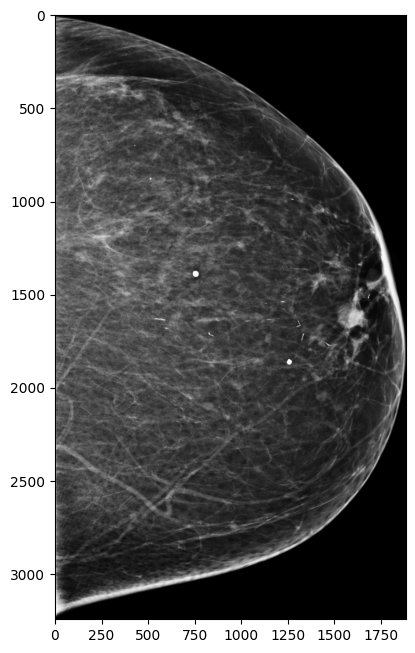

(3243, 1885, 3)


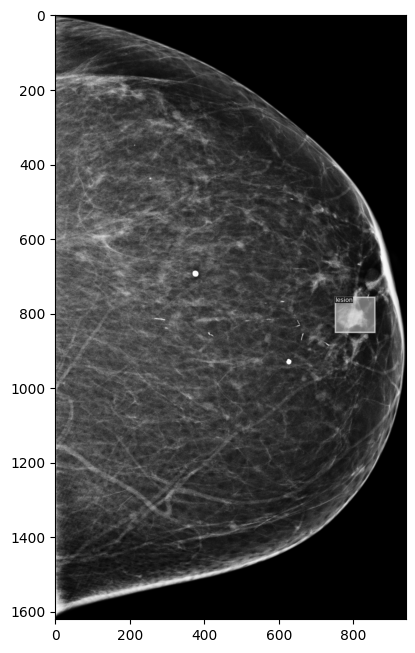

/mnt/mia_images/breast/iceberg_selection2/HOLOGIC/ffdm/st100/demd5268_9970_1.2.826.0.1.3680043.9.3218.1.1.2938075.9814.1512122328549.5627.0_CC.png


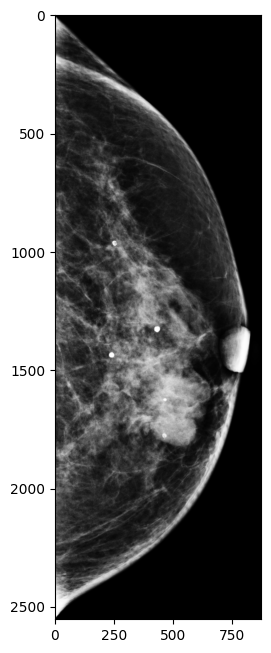

(2553, 873, 3)


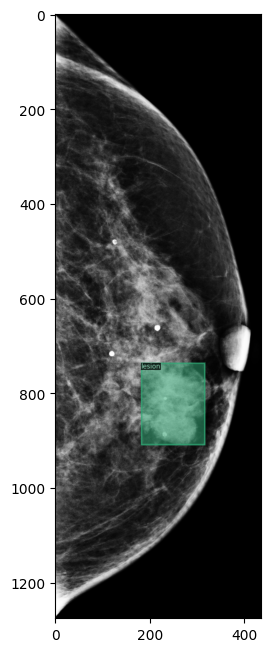

/mnt/mia_images/breast/iceberg_selection2/HOLOGIC/ffdm/st110/demd5347_9971_1.2.826.0.1.3680043.9.3218.1.1.293807.9814.1512122328549.10141.0_MLO.png


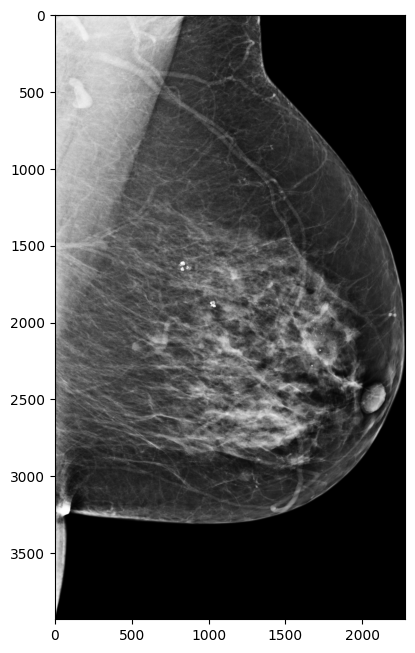

(3931, 2282, 3)


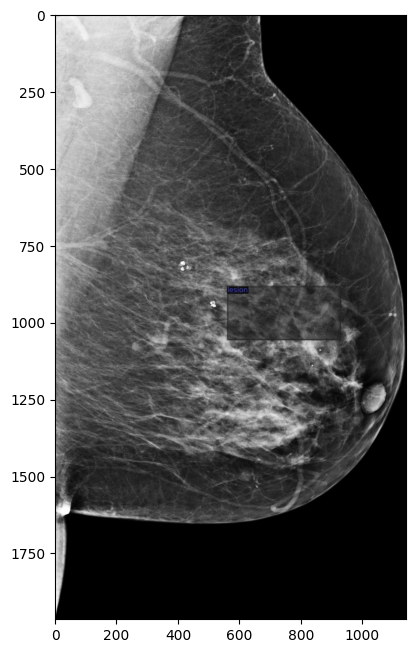

In [40]:
for d in random.sample(dataset_dicts, 3):
    print (d["file_name"])
    img = cv2.imread(d["file_name"])
    plt.imshow(img)
    plt.show()
    print((img.shape))
    visualizer = Visualizer(img[:, :, ::-1], metadata=omidb_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

## Train with omidb

In [12]:
from detectron2.engine import DefaultTrainer



if (not use_detr):
    # model_file = "./model/faster_rcnn_R2_101_FPN_3x.yaml"
    model_file = "COCO-Detection/faster_rcnn_"+m_layer+"_FPN_3x.yaml"
    # model_file = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

    # outputs
    omidb_model_file = "model_final_"+m_layer+"_omidb_"+p_omidb+"_"+g_rgb+".pth"
    dbt_model_file = "model_final_"+m_layer+"_omidb_"+p_omidb+"_dbt"+p_dbt+"_"+g_rgb+".pth"
    config_file = "config_trained_"+m_layer+"_"+p_omidb+".yaml"
else:
    model_file = "./model/converted_model.pth"
    omidb_model_file = "detr_final_"+m_layer+"_omidb_"+p_omidb+"_"+g_rgb+".pth"
    dbt_model_file = "detr_final_"+m_layer+"_omidb_"+p_omidb+"_dbt"+p_dbt+"_"+g_rgb+".pth"
#     config_file = "config_trained_"+m_layer+"_"+p_omidb+".yaml"
    config_file_in = "configs/detr_256_6_6_torchvision.yaml"
    config_file = "config_trained_detr"+m_layer+"_"+p_omidb+".yaml"
    


# config_file = "config_trained_R101_omidb.yaml"
# config_file = "config_trained_X_101_32x8d_FPN_3x_omidb.yaml"

In [13]:
print (omidb_model_file, dbt_model_file, config_file)

model_final_R_101_omidb_30k_gray.pth model_final_R_101_omidb_30k_dbt9k_f2_gray.pth config_trained_R_101_30k.yaml


In [14]:

cfg = get_cfg()
#  Trying res2net.
# cfg.merge_from_file(model_file)
# cfg.MODEL.WEIGHTS = "./model/r2_101.pkl"

# downloaded R101
# cfg.merge_from_file(model_zoo.get_config_file(model_file))
# cfg.MODEL.WEIGHTS = "./model/r_101.pkl"

if (use_detr):
    add_detr_config(cfg)
    cfg.merge_from_file(config_file_in)
    cfg.MODEL.DETR.NUM_OBJECT_QUERIES = 20 #10
    cfg.MODEL.WEIGHTS = model_file  # Let training initialize from model zoo
    cfg.MODEL.DETR.NUM_CLASSES = 1
    
#     cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 1e-5  # pick a good LR
    cfg.SOLVER.MAX_ITER = iter_detr_omidb #10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
#     cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)


else:
# change this for R101
    cfg.merge_from_file(model_zoo.get_config_file(model_file))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_file)  # Let training initialize from model zoo
    # cfg.MODEL.WEIGHTS = "./model/model_final_f6e8b1.pkl"  # Let training initialize from model zoo
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = iter_omidb #10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)



cfg.DATASETS.TRAIN = ("omidb_train",)
cfg.DATASETS.TEST = ()
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
if (use_detr): trainer = Trainer(cfg)
else: trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()



[09/27 09:26:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[09/27 09:26:08 d2.data.build]: Removed 4471 images with no usable annotations. 6794 images left.
[09/27 09:26:09 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   lesion   | 6794         |
|            |              |
[09/27 09:26:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/27 09:26:09 d2.data.build]: Using training sampler TrainingSampler
[09/27 09:26:09 d2.data.common]: Serializing 6794 elements to byte tensors and concatenating them all ...
[09/27 09:26:09 d2.data.common]: Serialized dataset takes 4.69 MiB
WARNING [09/27 09:26:09 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[09/27 09:26:12 d2.engine.train_loop]: Starting training from iteration 0


/home/robert/src/fb_detectron2/detectron2/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[09/27 09:26:16 d2.engine.hooks]: Overall training speed: 2 iterations in 0:00:01 (0.8050 s / it)
[09/27 09:26:16 d2.engine.hooks]: Total training time: 0:00:01 (0:00:00 on hooks)
[09/27 09:26:16 d2.utils.events]:  eta: 5:17:26  iter: 4  total_loss: 0.88  loss_cls: 0.6936  loss_box_reg: 0.001577  loss_rpn_cls: 0.1609  loss_rpn_loc: 0.01608  time: 0.6350  data_time: 0.5292  lr: 9.9925e-07  max_mem: 3527M


KeyboardInterrupt: 

In [29]:
# Save config to file
with open("output/"+config_file, "w") as f:
    f.write(cfg.dump())

In [ ]:
import os
os.rename(r'./output/model_final.pth',r'./output/'+omidb_model_file)


In [ ]:
import os
PATH = os.getenv('PATH')
%env PATH=/home/robert/miniconda2/envs/fast2/bin:$PATH
%load_ext tensorboard
%tensorboard --logdir output --host localhost --port 8885


### Test: Individual prediction with omidb


In [13]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = get_omidb_dicts("/mnt/mia_images/breast/iceberg_selection2")

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, omidb_model_file)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25 #0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("omidb_train", )

predictor = DefaultPredictor(cfg)

test_metadata = MetadataCatalog.get("omidb_train")
for d in random.sample(dataset_dicts, 3):    
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    out = outputs["instances"].to("cpu")
    print(out.pred_classes)
    print(out.pred_boxes)
    print(out.scores)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()
#     cv2_imshow(v.get_image()[:, :, ::-1])

NameError: name 'get_omidb_dicts' is not defined

## DBT dataset

In [35]:
DatasetCatalog.clear()

In [36]:
from detectron2.structures import BoxMode

import omidb

import pandas as pd
import io

def get_DBT_dicts(img_dir):
#    using a subset of the original challenge train?
#     csv_file = os.path.join(img_dir, "../train_bboxes.csv") ->> original challenge train
#     csv_file = os.path.join(img_dir, "../rob_local_train_bboxes.csv")  ->> subset of 75%
#     csv_file = os.path.join(img_dir, "/train_bboxes.csv") #->> original challenge train
    csv_file = os.path.join(img_dir, csv_dbt_file) #->> original challenge train

    
    df = pd.read_csv(csv_file,names=['Patient', 'Study', 'filename', 'side', 'bbox',  'slice', 'bbox_roi'])
    
    dataset_dicts = []
    
    for idx, row in df.iterrows():
        record = {}
        
        filename = os.path.join(img_dir, row["filename"])
#         print (filename)
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        bbox_roi = row["bbox_roi"][12:-1]
        coords = bbox_roi.split(',')
        r= np.array([0,0,0,0])
        idx = 0
        for c in coords:
            aux = c.split('=')
            r[idx]=(int(aux[1]))
            idx +=1
        bbox_roi = omidb.mark.BoundingBox(r[0],r[1],r[2],r[3])    
        px = [bbox_roi.x1, bbox_roi.x2, bbox_roi.x2, bbox_roi.x1]
        py = [bbox_roi.y1, bbox_roi.y1, bbox_roi.y2, bbox_roi.y2]
        poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
        poly = [p for x in poly for p in x]
        objs = []
        obj =  {
                "bbox": [bbox_roi.x1 , bbox_roi.y1, bbox_roi.x2, bbox_roi.y2],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

DatasetCatalog.register("DBT_train", lambda: get_DBT_dicts(dbt_dicts))
MetadataCatalog.get("DBT_train").set(thing_classes=["lesion"])
dbt_metadata = MetadataCatalog.get("DBT_train")
# for d in ["train", "val"]:
#     DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("/home/robert/src/detectron2/Res2Net-detectron2/balloon/" + d))
#     MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
# balloon_metadata = MetadataCatalog.get("balloon_train")


/home/robert/data/DBT2/train_gray/DBT-P03748_DBT-S02094_lcc_45.png


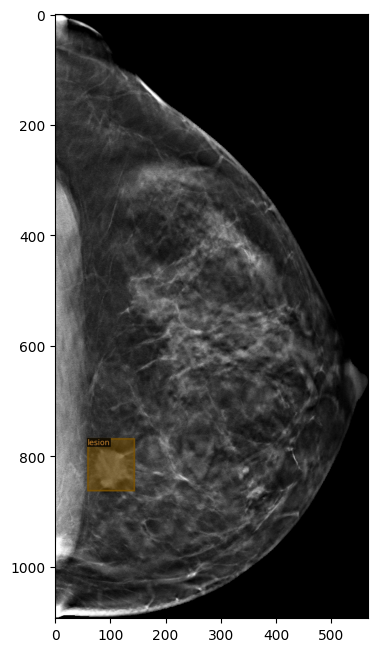

/home/robert/data/DBT2/train_gray/DBT-P03978_DBT-S00442_rmlo_10.png


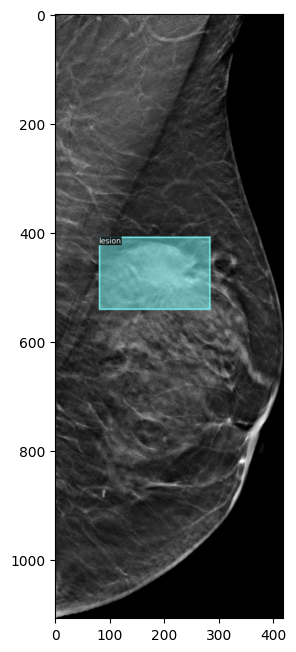

/home/robert/data/DBT2/train_gray/DBT-P04631_DBT-S05515_lcc_9.png


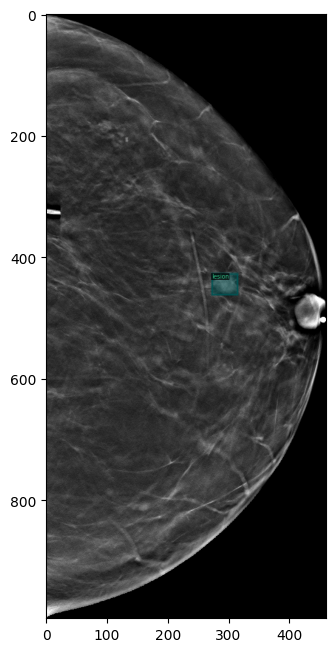

In [37]:
dataset_dicts = get_DBT_dicts(dbt_dicts)
for d in random.sample(dataset_dicts, 3):

    print (d["file_name"])
    img = cv2.imread(d["file_name"])
    #     plt.imshow(img)
    #     plt.show()
    #     print((img.shape))
    visualizer = Visualizer(img[:, :, ::-1], metadata=dbt_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [38]:
from detectron2.engine import DefaultTrainer



# we have already cfg file 
# cfg = get_cfg()

cfg.merge_from_file("./output/"+config_file)

cfg.DATASETS.TRAIN = ("DBT_train",)
cfg.DATASETS.TEST = ()

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, omidb_model_file)

if (use_detr):
    cfg.MODEL.DETR.NUM_OBJECT_QUERIES = 20
    cfg.MODEL.DETR.NUM_CLASSES = 1
    
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.MAX_ITER = iter_detr_dbt     # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR

else: 
    cfg.DATALOADER.NUM_WORKERS = 2
    # loading trained weights. 
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = iter_dbt # was 5000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
if (use_detr): trainer = Trainer(cfg)
else: trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Save config to file
with open("output/"+config_file, "w") as f:
    f.write(cfg.dump())

[07/12 14:24:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[07/12 14:24:46 d2.data.build]: Removed 0 images with no usable annotations. 120 images left.
[07/12 14:24:46 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   lesion   | 120          |
|            |              |
[07/12 14:24:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/12 14:24:46 d2.data.build]: Using training sampler TrainingSampler
[07/12 14:24:46 d2.data.common]: Serializing 120 elements to byte tensors and concatenating them all ...
[07/12 14:24:46 d2.data.common]: Serialized dataset takes 0.07 MiB
WARNING [07/12 14:24:46 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[07/12 14:24:46 d2.engine.train_loop]: Starting training from iteration 0
[07/12 14:24:52 d2.utils.events]:  eta: 0:47:

[07/12 14:28:06 d2.utils.events]:  eta: 0:44:38  iter: 619  total_loss: 0.1346  loss_cls: 0.05647  loss_box_reg: 0.07377  loss_rpn_cls: 0.002069  loss_rpn_loc: 0.003887  time: 0.3166  data_time: 0.0040  lr: 0.00015485  max_mem: 4180M
[07/12 14:28:13 d2.utils.events]:  eta: 0:44:33  iter: 639  total_loss: 0.1392  loss_cls: 0.04952  loss_box_reg: 0.07485  loss_rpn_cls: 0.004395  loss_rpn_loc: 0.003897  time: 0.3167  data_time: 0.0042  lr: 0.00015984  max_mem: 4180M
[07/12 14:28:19 d2.utils.events]:  eta: 0:44:27  iter: 659  total_loss: 0.1383  loss_cls: 0.05799  loss_box_reg: 0.07274  loss_rpn_cls: 0.001967  loss_rpn_loc: 0.003936  time: 0.3169  data_time: 0.0045  lr: 0.00016484  max_mem: 4180M
[07/12 14:28:26 d2.utils.events]:  eta: 0:44:20  iter: 679  total_loss: 0.1322  loss_cls: 0.04774  loss_box_reg: 0.06876  loss_rpn_cls: 0.00128  loss_rpn_loc: 0.003707  time: 0.3169  data_time: 0.0047  lr: 0.00016983  max_mem: 4180M
[07/12 14:28:32 d2.utils.events]:  eta: 0:44:14  iter: 699  total

[07/12 14:31:48 d2.utils.events]:  eta: 0:41:20  iter: 1299  total_loss: 0.08366  loss_cls: 0.02854  loss_box_reg: 0.05203  loss_rpn_cls: 0.0005445  loss_rpn_loc: 0.002664  time: 0.3187  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 14:31:54 d2.utils.events]:  eta: 0:41:14  iter: 1319  total_loss: 0.1002  loss_cls: 0.03415  loss_box_reg: 0.05619  loss_rpn_cls: 0.0003628  loss_rpn_loc: 0.002922  time: 0.3188  data_time: 0.0043  lr: 0.00025  max_mem: 4180M
[07/12 14:32:01 d2.utils.events]:  eta: 0:41:08  iter: 1339  total_loss: 0.08215  loss_cls: 0.02871  loss_box_reg: 0.05429  loss_rpn_cls: 0.0001528  loss_rpn_loc: 0.002364  time: 0.3189  data_time: 0.0044  lr: 0.00025  max_mem: 4180M
[07/12 14:32:08 d2.utils.events]:  eta: 0:41:02  iter: 1359  total_loss: 0.08995  loss_cls: 0.02877  loss_box_reg: 0.05489  loss_rpn_cls: 0.0005655  loss_rpn_loc: 0.002828  time: 0.3188  data_time: 0.0046  lr: 0.00025  max_mem: 4180M
[07/12 14:32:14 d2.utils.events]:  eta: 0:40:55  iter: 1379  tota

[07/12 14:35:32 d2.utils.events]:  eta: 0:38:06  iter: 1979  total_loss: 0.0623  loss_cls: 0.01936  loss_box_reg: 0.04045  loss_rpn_cls: 8.251e-05  loss_rpn_loc: 0.001816  time: 0.3206  data_time: 0.0043  lr: 0.00025  max_mem: 4180M
[07/12 14:35:38 d2.utils.events]:  eta: 0:38:00  iter: 1999  total_loss: 0.05821  loss_cls: 0.01688  loss_box_reg: 0.03848  loss_rpn_cls: 6.755e-05  loss_rpn_loc: 0.002162  time: 0.3206  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 14:35:45 d2.utils.events]:  eta: 0:37:53  iter: 2019  total_loss: 0.06002  loss_cls: 0.01891  loss_box_reg: 0.03734  loss_rpn_cls: 0.000215  loss_rpn_loc: 0.002041  time: 0.3206  data_time: 0.0040  lr: 0.00025  max_mem: 4180M
[07/12 14:35:52 d2.utils.events]:  eta: 0:37:46  iter: 2039  total_loss: 0.06268  loss_cls: 0.01977  loss_box_reg: 0.03688  loss_rpn_cls: 7.995e-05  loss_rpn_loc: 0.002301  time: 0.3206  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 14:35:58 d2.utils.events]:  eta: 0:37:40  iter: 2059  total

[07/12 14:39:15 d2.utils.events]:  eta: 0:34:16  iter: 2659  total_loss: 0.04986  loss_cls: 0.01528  loss_box_reg: 0.03253  loss_rpn_cls: 5.872e-05  loss_rpn_loc: 0.001786  time: 0.3208  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 14:39:21 d2.utils.events]:  eta: 0:34:13  iter: 2679  total_loss: 0.04224  loss_cls: 0.01352  loss_box_reg: 0.02923  loss_rpn_cls: 3.203e-05  loss_rpn_loc: 0.001519  time: 0.3208  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 14:39:28 d2.utils.events]:  eta: 0:34:07  iter: 2699  total_loss: 0.04021  loss_cls: 0.01248  loss_box_reg: 0.02435  loss_rpn_cls: 2.834e-05  loss_rpn_loc: 0.001646  time: 0.3208  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 14:39:34 d2.utils.events]:  eta: 0:34:00  iter: 2719  total_loss: 0.04815  loss_cls: 0.01663  loss_box_reg: 0.03215  loss_rpn_cls: 5.511e-05  loss_rpn_loc: 0.00159  time: 0.3208  data_time: 0.0039  lr: 0.00025  max_mem: 4180M
[07/12 14:39:41 d2.utils.events]:  eta: 0:33:56  iter: 2739  tota

[07/12 14:42:57 d2.utils.events]:  eta: 0:30:29  iter: 3339  total_loss: 0.04113  loss_cls: 0.0118  loss_box_reg: 0.02428  loss_rpn_cls: 1.95e-05  loss_rpn_loc: 0.001525  time: 0.3210  data_time: 0.0043  lr: 0.00025  max_mem: 4180M
[07/12 14:43:03 d2.utils.events]:  eta: 0:30:24  iter: 3359  total_loss: 0.03385  loss_cls: 0.01186  loss_box_reg: 0.02109  loss_rpn_cls: 2.549e-05  loss_rpn_loc: 0.001251  time: 0.3210  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 14:43:10 d2.utils.events]:  eta: 0:30:18  iter: 3379  total_loss: 0.03672  loss_cls: 0.01091  loss_box_reg: 0.02433  loss_rpn_cls: 4.81e-05  loss_rpn_loc: 0.00108  time: 0.3209  data_time: 0.0038  lr: 0.00025  max_mem: 4180M
[07/12 14:43:16 d2.utils.events]:  eta: 0:30:10  iter: 3399  total_loss: 0.03938  loss_cls: 0.01401  loss_box_reg: 0.02311  loss_rpn_cls: 1.305e-05  loss_rpn_loc: 0.001284  time: 0.3209  data_time: 0.0036  lr: 0.00025  max_mem: 4180M
[07/12 14:43:23 d2.utils.events]:  eta: 0:30:02  iter: 3419  total_l

[07/12 14:46:39 d2.utils.events]:  eta: 0:26:57  iter: 4019  total_loss: 0.02924  loss_cls: 0.01052  loss_box_reg: 0.01753  loss_rpn_cls: 1.093e-05  loss_rpn_loc: 0.001286  time: 0.3212  data_time: 0.0043  lr: 0.00025  max_mem: 4180M
[07/12 14:46:45 d2.utils.events]:  eta: 0:26:53  iter: 4039  total_loss: 0.02834  loss_cls: 0.01036  loss_box_reg: 0.01697  loss_rpn_cls: 2.842e-05  loss_rpn_loc: 0.001384  time: 0.3212  data_time: 0.0047  lr: 0.00025  max_mem: 4180M
[07/12 14:46:52 d2.utils.events]:  eta: 0:26:48  iter: 4059  total_loss: 0.02879  loss_cls: 0.009009  loss_box_reg: 0.01761  loss_rpn_cls: 1.735e-05  loss_rpn_loc: 0.001517  time: 0.3212  data_time: 0.0040  lr: 0.00025  max_mem: 4180M
[07/12 14:46:58 d2.utils.events]:  eta: 0:26:42  iter: 4079  total_loss: 0.0321  loss_cls: 0.01084  loss_box_reg: 0.02082  loss_rpn_cls: 1.576e-05  loss_rpn_loc: 0.001237  time: 0.3212  data_time: 0.0035  lr: 0.00025  max_mem: 4180M
[07/12 14:47:04 d2.utils.events]:  eta: 0:26:34  iter: 4099  tot

[07/12 14:50:20 d2.utils.events]:  eta: 0:23:21  iter: 4699  total_loss: 0.02795  loss_cls: 0.00873  loss_box_reg: 0.01824  loss_rpn_cls: 1.224e-05  loss_rpn_loc: 0.001074  time: 0.3214  data_time: 0.0043  lr: 0.00025  max_mem: 4180M
[07/12 14:50:27 d2.utils.events]:  eta: 0:23:14  iter: 4719  total_loss: 0.02539  loss_cls: 0.008313  loss_box_reg: 0.01526  loss_rpn_cls: 1.166e-05  loss_rpn_loc: 0.001074  time: 0.3215  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 14:50:33 d2.utils.events]:  eta: 0:23:08  iter: 4739  total_loss: 0.02875  loss_cls: 0.009501  loss_box_reg: 0.01804  loss_rpn_cls: 1.137e-05  loss_rpn_loc: 0.001017  time: 0.3215  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 14:50:40 d2.utils.events]:  eta: 0:23:00  iter: 4759  total_loss: 0.02652  loss_cls: 0.009938  loss_box_reg: 0.01578  loss_rpn_cls: 2.658e-05  loss_rpn_loc: 0.001038  time: 0.3214  data_time: 0.0040  lr: 0.00025  max_mem: 4180M
[07/12 14:50:46 d2.utils.events]:  eta: 0:22:54  iter: 4779  

[07/12 14:54:03 d2.utils.events]:  eta: 0:19:28  iter: 5379  total_loss: 0.02577  loss_cls: 0.009122  loss_box_reg: 0.01482  loss_rpn_cls: 1.76e-05  loss_rpn_loc: 0.001021  time: 0.3213  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 14:54:09 d2.utils.events]:  eta: 0:19:22  iter: 5399  total_loss: 0.02733  loss_cls: 0.008026  loss_box_reg: 0.0166  loss_rpn_cls: 1.238e-05  loss_rpn_loc: 0.001057  time: 0.3213  data_time: 0.0039  lr: 0.00025  max_mem: 4180M
[07/12 14:54:16 d2.utils.events]:  eta: 0:19:18  iter: 5419  total_loss: 0.02444  loss_cls: 0.008636  loss_box_reg: 0.01535  loss_rpn_cls: 1.31e-05  loss_rpn_loc: 0.0011  time: 0.3213  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 14:54:23 d2.utils.events]:  eta: 0:19:15  iter: 5439  total_loss: 0.02304  loss_cls: 0.008502  loss_box_reg: 0.01465  loss_rpn_cls: 6.961e-06  loss_rpn_loc: 0.0008826  time: 0.3214  data_time: 0.0043  lr: 0.00025  max_mem: 4180M
[07/12 14:54:29 d2.utils.events]:  eta: 0:19:09  iter: 5459  tot

[07/12 14:57:41 d2.utils.events]:  eta: 0:15:48  iter: 6059  total_loss: 0.02778  loss_cls: 0.009047  loss_box_reg: 0.01617  loss_rpn_cls: 1.147e-05  loss_rpn_loc: 0.001064  time: 0.3210  data_time: 0.0039  lr: 0.00025  max_mem: 4180M
[07/12 14:57:48 d2.utils.events]:  eta: 0:15:43  iter: 6079  total_loss: 0.02413  loss_cls: 0.008613  loss_box_reg: 0.01512  loss_rpn_cls: 7.139e-06  loss_rpn_loc: 0.0008543  time: 0.3210  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 14:57:54 d2.utils.events]:  eta: 0:15:35  iter: 6099  total_loss: 0.02494  loss_cls: 0.008481  loss_box_reg: 0.01531  loss_rpn_cls: 1.136e-05  loss_rpn_loc: 0.001108  time: 0.3210  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 14:58:00 d2.utils.events]:  eta: 0:15:28  iter: 6119  total_loss: 0.02558  loss_cls: 0.008362  loss_box_reg: 0.01553  loss_rpn_cls: 9.182e-06  loss_rpn_loc: 0.000897  time: 0.3210  data_time: 0.0039  lr: 0.00025  max_mem: 4180M
[07/12 14:58:07 d2.utils.events]:  eta: 0:15:22  iter: 6139

[07/12 15:01:20 d2.utils.events]:  eta: 0:12:05  iter: 6739  total_loss: 0.02166  loss_cls: 0.007129  loss_box_reg: 0.01286  loss_rpn_cls: 3.976e-06  loss_rpn_loc: 0.0008834  time: 0.3208  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 15:01:27 d2.utils.events]:  eta: 0:11:59  iter: 6759  total_loss: 0.0208  loss_cls: 0.007668  loss_box_reg: 0.01452  loss_rpn_cls: 1.949e-05  loss_rpn_loc: 0.001106  time: 0.3208  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 15:01:33 d2.utils.events]:  eta: 0:11:52  iter: 6779  total_loss: 0.02462  loss_cls: 0.007913  loss_box_reg: 0.01558  loss_rpn_cls: 1.324e-05  loss_rpn_loc: 0.0009989  time: 0.3208  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 15:01:40 d2.utils.events]:  eta: 0:11:46  iter: 6799  total_loss: 0.02309  loss_cls: 0.007163  loss_box_reg: 0.01353  loss_rpn_cls: 1.336e-05  loss_rpn_loc: 0.0009566  time: 0.3208  data_time: 0.0042  lr: 0.00025  max_mem: 4180M
[07/12 15:01:46 d2.utils.events]:  eta: 0:11:40  iter: 681

[07/12 15:05:02 d2.utils.events]:  eta: 0:08:33  iter: 7419  total_loss: 0.02084  loss_cls: 0.006592  loss_box_reg: 0.01172  loss_rpn_cls: 1.262e-05  loss_rpn_loc: 0.0009265  time: 0.3211  data_time: 0.0041  lr: 0.00025  max_mem: 4180M
[07/12 15:05:09 d2.utils.events]:  eta: 0:08:26  iter: 7439  total_loss: 0.02005  loss_cls: 0.006874  loss_box_reg: 0.01195  loss_rpn_cls: 4.872e-06  loss_rpn_loc: 0.000678  time: 0.3211  data_time: 0.0039  lr: 0.00025  max_mem: 4180M
[07/12 15:05:15 d2.utils.events]:  eta: 0:08:20  iter: 7459  total_loss: 0.02231  loss_cls: 0.007909  loss_box_reg: 0.0127  loss_rpn_cls: 6.022e-06  loss_rpn_loc: 0.0008159  time: 0.3211  data_time: 0.0040  lr: 0.00025  max_mem: 4180M
[07/12 15:05:22 d2.utils.events]:  eta: 0:08:14  iter: 7479  total_loss: 0.02247  loss_cls: 0.008184  loss_box_reg: 0.01328  loss_rpn_cls: 1.004e-05  loss_rpn_loc: 0.0009811  time: 0.3211  data_time: 0.0040  lr: 0.00025  max_mem: 4180M
[07/12 15:05:28 d2.utils.events]:  eta: 0:08:07  iter: 749

[07/12 15:08:43 d2.utils.events]:  eta: 0:04:53  iter: 8099  total_loss: 0.02032  loss_cls: 0.006314  loss_box_reg: 0.01163  loss_rpn_cls: 8.384e-06  loss_rpn_loc: 0.0009168  time: 0.3211  data_time: 0.0043  lr: 0.00025  max_mem: 4180M
[07/12 15:08:50 d2.utils.events]:  eta: 0:04:46  iter: 8119  total_loss: 0.01933  loss_cls: 0.007475  loss_box_reg: 0.01185  loss_rpn_cls: 6.052e-06  loss_rpn_loc: 0.0007393  time: 0.3212  data_time: 0.0045  lr: 0.00025  max_mem: 4180M
[07/12 15:08:56 d2.utils.events]:  eta: 0:04:40  iter: 8139  total_loss: 0.0175  loss_cls: 0.005035  loss_box_reg: 0.01044  loss_rpn_cls: 1.172e-05  loss_rpn_loc: 0.0008693  time: 0.3212  data_time: 0.0044  lr: 0.00025  max_mem: 4180M
[07/12 15:09:03 d2.utils.events]:  eta: 0:04:33  iter: 8159  total_loss: 0.02165  loss_cls: 0.006858  loss_box_reg: 0.01132  loss_rpn_cls: 6.127e-06  loss_rpn_loc: 0.0008392  time: 0.3212  data_time: 0.0043  lr: 0.00025  max_mem: 4180M
[07/12 15:09:09 d2.utils.events]:  eta: 0:04:27  iter: 81

[07/12 15:12:25 d2.utils.events]:  eta: 0:01:11  iter: 8779  total_loss: 0.01832  loss_cls: 0.006003  loss_box_reg: 0.009966  loss_rpn_cls: 5.01e-06  loss_rpn_loc: 0.0006844  time: 0.3212  data_time: 0.0034  lr: 0.00025  max_mem: 4180M
[07/12 15:12:31 d2.utils.events]:  eta: 0:01:05  iter: 8799  total_loss: 0.02025  loss_cls: 0.006336  loss_box_reg: 0.0125  loss_rpn_cls: 6.411e-06  loss_rpn_loc: 0.0006758  time: 0.3212  data_time: 0.0035  lr: 0.00025  max_mem: 4180M
[07/12 15:12:37 d2.utils.events]:  eta: 0:00:58  iter: 8819  total_loss: 0.01938  loss_cls: 0.005823  loss_box_reg: 0.01163  loss_rpn_cls: 7.138e-06  loss_rpn_loc: 0.0008273  time: 0.3212  data_time: 0.0038  lr: 0.00025  max_mem: 4180M
[07/12 15:12:44 d2.utils.events]:  eta: 0:00:52  iter: 8839  total_loss: 0.01865  loss_cls: 0.005808  loss_box_reg: 0.01118  loss_rpn_cls: 6.699e-06  loss_rpn_loc: 0.0007104  time: 0.3212  data_time: 0.0035  lr: 0.00025  max_mem: 4180M
[07/12 15:12:50 d2.utils.events]:  eta: 0:00:45  iter: 88

In [1]:
import os
PATH = os.getenv('PATH')
%env PATH=/home/robert/miniconda2/envs/fast2/bin:$PATH
%load_ext tensorboard
%tensorboard --logdir output --host localhost --port 8885



env: PATH=/home/robert/miniconda2/envs/fast2/bin:/home/robert/miniconda2/envs/fast2/bin:/home/robert/bin:/home/robert/.local/bin:/usr/local/cuda/bin:/home/robert/bin:/home/robert/.local/bin:/home/robert/miniconda2/bin:/home/robert/miniconda2/condabin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [41]:
# saving dbt model
import os
os.rename(r'./output/model_final.pth',r'./output/'+dbt_model_file)


FileNotFoundError: [Errno 2] No such file or directory: './output/model_final.pth' -> './output/model_final_R_101_omidb_30k_dbt9k_f2_gray.pth'

## Checking specific ground truths

In [ ]:
dataset_dicts = get_DBT_dicts(dbt_dicts)

search_fn = 'DBT-P04750_DBT-S00052_rcc_15.png'# seems tissue
search_fn = 'DBT-P03677_DBT-S00709_lcc_42'
search_fn = 'DBT-P03677_DBT-S00709_lmlo_' #spiculated difficult
search_fn = 'DBT-P02750' # out of the image
search_fn = 'DBT-P02579_DBT-S00929_lmlo_14' # spiculated difficult large
search_fn = 'DBT-P02380_DBT-S01233_lmlo_29'
search_fn = 'DBT-P02919_DBT-S01259_lcc_29'
search_fn = 'DBT-P02919_DBT-S01259_rcc_48.png'
search_fn = 'DBT-P02919_DBT-S01259_rmlo_26.png'
search_fn = 'DBT-P05056_DBT-S01839_rcc_44'
search_fn = 'DBT-P05056_DBT-S01839_rmlo_22'
search_fn = 'DBT-P03658_DBT-S05241_lcc_15'




# d = list(filter(lambda filename: filename['file_name'] == 'DBT-P04750_DBT-S00052_rcc_15.png', dataset_dicts))
d = next((item for item in dataset_dicts if search_fn in item["file_name"] ), None)
print(d)


img = cv2.imread(d["file_name"])
plt.imshow(img)
plt.show()
#     print((img.shape))
visualizer = Visualizer(img[:, :, ::-1], metadata=dbt_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

### Individual prediction


In [ ]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, dbt_model_file)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1 #0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("DBT_train", )

predictor = DefaultPredictor(cfg)

test_metadata = MetadataCatalog.get("DBT_train")
for d in random.sample(dataset_dicts, 3):    
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    out = outputs["instances"].to("cpu")
    print(out.pred_classes)
    print(out.pred_boxes)
    print(out.scores)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()
#     cv2_imshow(v.get_image()[:, :, ::-1])

### Prediction using COCOEvaluator

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "balloon_val")
evaluator = COCOEvaluator("DBT_train", ("bbox","segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "DBT_train")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`